### Problem Statement

text here

image here

### 1) Imports

In [1]:
from __future__ import print_function           # Use print() instead of print
from __future__ import division                 # 1 / 2 = 0.5, 1 // 2 = 0
import numpy as np                              # for numpy
import torch                                    # import PyTorch module 
import torch.nn as nn                           # neural network module
from torch.utils.data import DataLoader         # dataloader abstracts sampling of minibatch
import torchvision.datasets as dset             # standard machine learning datasets
import torchvision.transforms as tform          # transforms for data augmentation
from torch.autograd import Variable             # auto differentiation
import sd_utils as utils                        # some python helper functions ( see: sd_utils.py )
import skimage                                  # for image processing. Note: image is simple a numpy array !!
import skimage.io as skio                       # for image read, write, show operations
from pprint import pprint                       # for pretty printing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import nltk

### 2) Hyper Parmaters and Initializations

In [2]:
crop_size = 224                                  # standard crop size used by many pretrained networks
mean_rgb = (0.485, 0.456, 0.406)                 # precomputed mean value ( assume given : its easy to compute, but lets not focus on it)
std_rgb = (0.229, 0.224, 0.225)                  # precomputed std dev value
batch_size = 256
num_workers = 4

img_dir = '../data/lab5/coco/resized2014/'
annotations_file = '../data/lab5/coco/annotations/captions_train2014.json'
threshold = 4

### 3) Download and Preprocess Dataset

In [3]:
# utils.mkdir_p('../data')
# utils.mkdir_p('../data/lab5')
# utils.mkdir_p('../data/lab5/coco')
# utils.mkdir_p('../data/lab5/coco/resized2014')

transform = tform.Compose([ 
        tform.RandomCrop(crop_size),
        tform.RandomHorizontalFlip(), 
        tform.ToTensor(), 
        tform.Normalize(mean_rgb, std_rgb)])



dset_train = dset.CocoCaptions(root=img_dir,
                              annFile=annotations_file,
                              transform=transform
                             )

loading annotations into memory...
Done (t=1.29s)
creating index...
index created!


Lets have a look at what kind of data we have. Pick one arbitrary image and visualize it along with its captions. For the image to display, we need to undo to normalization

Number of samples:  82783
Image Size:  torch.Size([3, 224, 224])
Image:


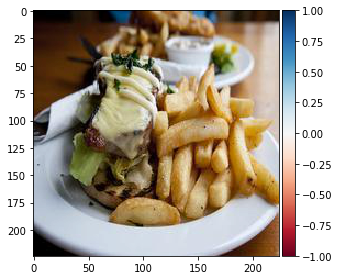

Captions:
[u'A plate topped with an open face sandwich and french fries.',
 u'A plate of fries with some other food on a plate',
 u'A plate holds an open sandwich and french fries.',
 u'A close view of a plate of food which includes fries',
 u'an image of a plate of food on a table']


In [4]:
print('Number of samples: ', len(dset_train))
img, target = dset_train[45] # load some sample
print("Image Size: ", img.size())
print("Image:")
cimg = img.clone().numpy()
nimg = cimg * np.array(std_rgb).reshape(3,1,1) + np.array(mean_rgb).reshape(3,1,1)
nimg = nimg.transpose([1,2,0])
skio.imshow(nimg)
skio.show()
print("Captions:")
pprint(target)

### 4) Create DataLoader objects

In [5]:
 dloader_train = torch.utils.data.DataLoader(dataset=dset_train, 
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=num_workers,
                                            )

In [6]:
#itr = iter(dloader_train)
# print(next(itr))

In [7]:
# %%time

# # le = LabelEncoder()
# c = Counter()

# for _, lbl in dset_train:
#     for y in lbl:
#         c.update(y)
        



In [8]:
%%time
from itertools import chain

threshold = 1000

dloader_train_seq = torch.utils.data.DataLoader(dataset=dset_train, 
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers,
                                            )
ctr = Counter()
for i,(_, lbl) in enumerate(dloader_train_seq):
    lbl_list = list(chain(*lbl))
#     print(lbl_list)
    for x in lbl_list:
        tokens = nltk.tokenize.word_tokenize(x.lower())
        # print(tokens)
        ctr.update(tokens)
    # break
        
#print(ctr)
words = [word for word, cnt in ctr.items() if cnt >= threshold]
print(words)

[u'hanging', u'wooden', u'kids', u'mouth', u'plate', u'lots', u'.', u'has', u'hat', u'crowd', u'passenger', u'chair', u'surfing', u'one', u'zoo', u'being', u'traffic', u'with', u'sand', u'small', u'past', u'clock', u'full', u'door', u'paper', u'signs', u'smiling', u'couple', u'into', u'video', u'next', u'baby', u'forest', u'glasses', u'scene', u'riding', u'off', u'coffee', u'train', u'another', u'dogs', u'giraffes', u'kitchen', u'hand', u'on', u'night', u'guy', u'decker', u'skiers', u'cabinets', u'tracks', u'horse', u'station', u'grey', u'empty', u'showing', u'wave', u'camera', u'pulling', u'during', u'dressed', u'intersection', u'home', u'display', u'men', u'room', u'luggage', u'microwave', u'skateboarder', u'tennis', u'jacket', u'filled', u'box', u'boy', u'making', u'monitor', u'elephants', u'jumping', u'seat', u'across', u'sleeping', u'outdoor', u'knife', u'sitting', u'coming', u'through', u'couch', u'motorcycles', u'restaurant', u'cut', u'cup', u'holds', u'skateboard', u'have', u'r

In [10]:
words = ['<pad>', '<start>', '<end>', '<unk>'] + words   # add additional tokens

In [13]:
le = LabelEncoder()
le.fit(words)
le.transform(['river', 'hanging', 'oranges'])

array([336, 194, 290])

### 5) Define Network

### 6) Define Loss function and Optimizer

### 7) Training Loop

### 8) Testing Loop

### 9) Save / Load Model